In [367]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [369]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import display

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsRegressor 

from sklearn.linear_model import ElasticNet, Ridge, Lasso, Lars
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

# pip install category-encoders

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.metrics import classification_report, mean_absolute_percentage_error

### Область работы 2 (поиск  модели .... )

In [73]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# оставляйте свои комментарии и разъяснения
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 

path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

In [74]:
diamonds = pd.read_csv(path_train)
diamonds.head()

,size,color,clarity,cut,symmetry,polish,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,Excellent,Excellent,61.4,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,Excellent,Very Good,61.9,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,Excellent,Excellent,63.0,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,Excellent,Excellent,63.2,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,Very Good,Excellent,63.4,61.0,4.24,4.26,2.69,864


In [75]:
display(diamonds.info())
display(diamonds.describe().T.style.background_gradient(cmap = 'Reds'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67598 entries, 0 to 67597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   size               67598 non-null  float64
 1   color              67598 non-null  object 
 2   clarity            67598 non-null  object 
 3   cut                67598 non-null  object 
 4   symmetry           67598 non-null  object 
 5   polish             67598 non-null  object 
 6   depth_percent      67598 non-null  float64
 7   table_percent      67598 non-null  float64
 8   meas_length        67598 non-null  float64
 9   meas_width         67598 non-null  float64
 10  meas_depth         67598 non-null  float64
 11  total_sales_price  67598 non-null  int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 6.2+ MB


None

,count,mean,std,min,25%,50%,75%,max
size,67598.000000,0.504181,0.306526,0.150000,0.300000,0.400000,0.570000,2.000000
depth_percent,67598.000000,62.106799,1.309775,55.000000,61.400000,62.300000,62.800000,66.500000
table_percent,67598.000000,57.793840,1.853719,0.000000,56.000000,58.000000,59.000000,67.000000
meas_length,67598.000000,4.911646,0.869997,2.270000,4.290000,4.600000,5.290000,8.180000
meas_width,67598.000000,4.943448,0.875224,3.420000,4.310000,4.640000,5.330000,8.230000
meas_depth,67598.000000,3.060767,0.545834,0.000000,2.680000,2.880000,3.290000,6.860000
total_sales_price,67598.000000,2755.178393,3341.411466,242.000000,898.000000,1236.000000,3208.000000,19996.000000


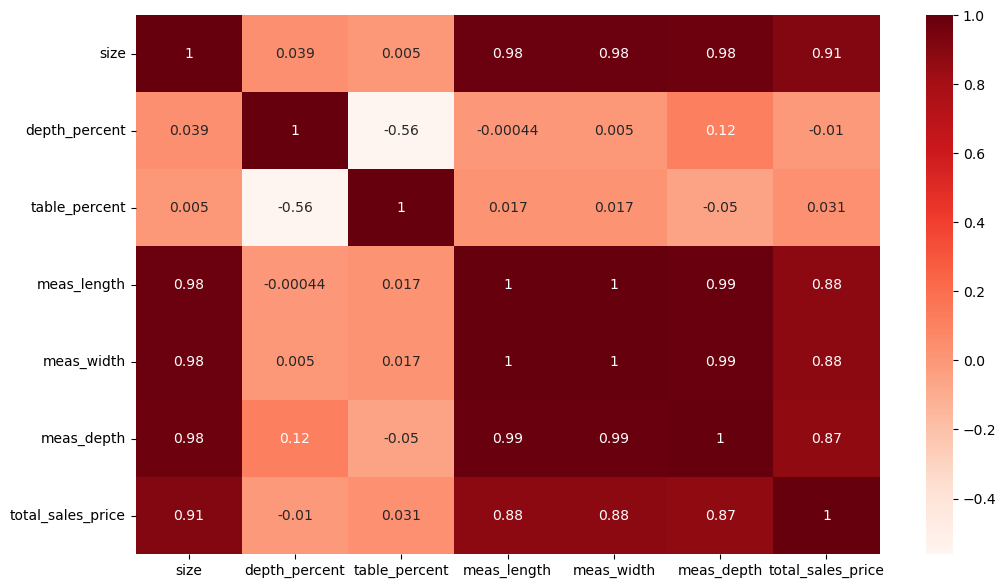

In [76]:
plt.figure(figsize=(12,7))
sns.heatmap(diamonds.drop(['symmetry', 'polish', 'color', 'clarity', 'cut'], axis=1).corr(),annot=True,cmap='Reds')
plt.show()

Посмотрим есть ли дублекаты, если что удалим их

In [77]:
diamonds.duplicated().sum()

192

In [78]:
diamonds.drop_duplicates(inplace = True)

In [79]:
diamonds.duplicated().sum()

0

In [80]:
label_encoder = LabelEncoder()
df = diamonds.copy()
df['symmetry'] = label_encoder.fit_transform(df['symmetry'])
df['polish'] = label_encoder.fit_transform(df['polish'])
df.head()

,size,color,clarity,cut,symmetry,polish,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,0,0,61.4,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,0,1,61.9,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,0,0,63.0,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,0,0,63.2,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,1,0,63.4,61.0,4.24,4.26,2.69,864


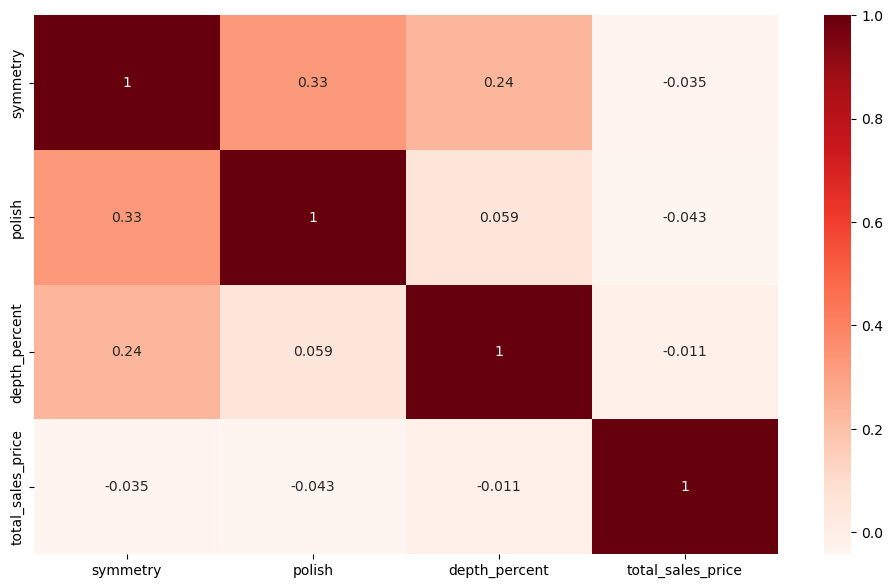

In [81]:
plt.figure(figsize=(12,7))
sns.heatmap(df[['symmetry', 'polish', 'depth_percent', 'total_sales_price']].corr(),annot=True,cmap='Reds')
plt.show()

Симметрию, полировку и depth_percent мы хотим удалить, так как они слабо влияют на цену бриллианта

In [82]:
diamonds = diamonds.drop(['symmetry', 'polish', 'depth_percent'], axis = 1)
diamonds.head()

,size,color,clarity,cut,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,61.0,4.24,4.26,2.69,864


In [83]:
y = np.array(diamonds.total_sales_price)
X = diamonds.drop(columns=['total_sales_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Выделим фичи

In [84]:
cat_features = ['cut']
axis_features = ['meas_length','meas_width','meas_depth']
num_features = ['size', 'table_percent']

Для цвета и чистоты мы хотим сделать градацию от лучшего к худшему

In [14]:
display(diamonds['color'].unique())
diamonds['color'].nunique()

array(['K', 'E', 'G', 'F', 'H', 'J', 'M', 'L', 'I', 'D'], dtype=object)

10

In [15]:
display(diamonds['clarity'].unique())
diamonds['clarity'].nunique()

array(['SI2', 'VVS2', 'VS2', 'VVS1', 'I2', 'SI1', 'I1', 'VS1', 'IF', 'I3'],
      dtype=object)

10

![title](цвет_бриллиантов.jpeg)

In [36]:
axis_transformer = Pipeline(steps = [
    ('imputer', KNNImputer(missing_values = 0, n_neighbors = 4, weights = "uniform")),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', StandardScaler())])

clarity_map = [{
    'col':'clarity',
    'mapping':{'IF':10, 'VVS1':9, 'VVS2':8, 'VS1':7, 'VS2':6, 
               'SI1':5, 'SI2':4, 'I1':3, 'I2':2, 'I3':1}
    }]

clarity_transformer = Pipeline(steps = [
    ('ce',ce.OrdinalEncoder(mapping = clarity_map)),
    ('scaler', StandardScaler())
    ])

color_map = [{
    'col':'color',
    'mapping':{'D':10, 'E':9, 'F':8, 'G':7, 'H':6, 'I':5, 
               'J':4, 'K':3, 'L':2, 'M':1}
    }]

color_transformer = Pipeline(steps = [
    ('ce',ce.OrdinalEncoder(mapping = color_map)),
    ('scaler', StandardScaler())
    ])
    
CT = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_clarity_map", clarity_transformer, ['clarity']),
        ("ordinal_color_map", color_transformer, ['color'])
        ])

display(CT)

res_ct = CT.fit_transform(X_train)
pd.DataFrame(res_ct).head()

ColumnTransformer(transformers=[('pol_std',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(missing_values=0,
                                                             n_neighbors=4)),
                                                 ('polynom',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['meas_length', 'meas_width', 'meas_depth']),
                                ('num', StandardScaler(),
                                 ['size', 'depth_percent', 'table_percent']),
                                ('cat', OneHotEncoder(), ['cut']),
                                ('ordinal_clar...
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': IF      10
VVS1     9
VVS2     8
VS1      7
VS2      6
SI1      5
SI2      4
I1       3
I2       2
I3       1
dtype: int64}])),
                                                 ('scaler', StandardScaler())]),
                                 ['clarity']),
                                ('ordinal_color_map',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'color',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': D    10
E     9
F     8
G     7
H     6
I     5
J     4
K     3
L     2
M     1
dtype: int64}])),
                                                 ('scaler', StandardScaler())]),
                                 ['color'])])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.356493,0.340837,0.348378,0.253176,0.245737,0.250808,0.238203,0.243183,0.245562,0.119045,-0.004916,-0.960676,1.0,0.0,0.240246,0.894912
1,-0.772930,-0.724591,-0.754557,-0.732683,-0.713878,-0.727822,-0.694812,-0.708828,-0.720297,-0.666967,-0.081247,0.650123,1.0,0.0,0.240246,-0.794618
2,-0.254317,-0.277799,-0.497206,-0.305355,-0.315525,-0.411958,-0.325672,-0.421705,-0.512501,-0.437714,-2.065848,1.187056,1.0,0.0,1.296414,-1.639383
3,0.264296,0.249187,0.164556,0.165041,0.157961,0.118593,0.150800,0.111461,0.070943,0.020793,-0.691894,0.113190,1.0,0.0,0.240246,1.317295
4,1.785560,1.784320,1.543225,1.793322,1.792934,1.656490,1.792167,1.655456,1.513592,1.625569,-1.455202,1.723989,1.0,0.0,-0.287838,0.050147


Посмотрим на разные регрессионные модели

In [31]:
pipe = Pipeline([('preprocessing', CT), 
                 ('classifier', KNeighborsRegressor())])

regressors = [Ridge(), ElasticNet(), Lars(), Lasso(), KNeighborsRegressor()]
param_grid = [
    {
        'classifier': regressors
    },
]

grid = GridSearchCV(pipe, param_grid, cv = KFold(5), return_train_score = True, scoring = 'neg_mean_absolute_percentage_error', n_jobs=-1)
grid.fit(X_train, y_train)

/Users/y1ov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+09, tolerance: 4.513e+07
  model = cd_fast.enet_coordinate_descent(
/Users/y1ov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+09, tolerance: 4.446e+07
  model = cd_fast.enet_coordinate_descent(
/Users/y1ov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pol_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(missing_values=0,
                                                                                                     n_neighbors=4)),
                                                                                         ('polynom',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['meas_length',
                                                                          'meas_width',
                                                                          'meas_depth']),
                                                                        ('n...
                                                                                          OrdinalEncoder(mapping=[{'col': 'color',
                                                                                                                   'data_type': dtype('O'),
                                                                                                                   'mapping': D    10
E     9
F     8
G     7
H     6
I     5
J     4
K     3
L     2
M     1
dtype: int64}])),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['color'])])),
                                       ('classifier', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'classifier': [Ridge(), ElasticNet(), Lars(), Lasso(),
                                         KNeighborsRegressor()]}],
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [32]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,4,3,0,1,2
mean_fit_time,0.069042,0.741117,0.09176,0.152992,0.080868
std_fit_time,0.010995,0.047079,0.007348,0.015352,0.007825
mean_score_time,1.957242,0.009992,0.015104,0.016591,0.012913
std_score_time,0.024135,0.00171,0.00436,0.007758,0.004488
param_classifier,KNeighborsRegressor(),Lasso(),Ridge(),ElasticNet(),Lars()
params,{'classifier': KNeighborsRegressor()},{'classifier': Lasso()},{'classifier': Ridge()},{'classifier': ElasticNet()},{'classifier': Lars()}
split0_test_score,-0.089257,-0.367737,-0.367866,-0.392433,-0.460874
split1_test_score,-0.08857,-0.36597,-0.365772,-0.392827,-50.700479
split2_test_score,-0.088837,-0.357013,-0.357441,-0.385386,-26.823192
split3_test_score,-0.088697,-0.370493,-0.370471,-0.390076,-0.385675


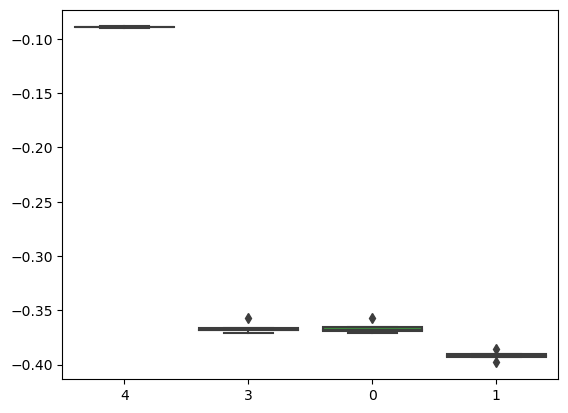

In [87]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:4]
sns.boxplot(data = tabl);

Можно сделать вывод, что KNeighbor будет лучшей моделью для решения этой задачи, так как очевидно, что с ней будет лучшая метрика

In [38]:
axis_transformer = Pipeline(steps = [
    ('imputer', KNNImputer(missing_values = 0, n_neighbors = 4, weights = "uniform")),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', StandardScaler())])

clarity_map = [{
    'col':'clarity',
    'mapping':{'IF':10, 'VVS1':9, 'VVS2':8, 'VS1':7, 'VS2':6, 
               'SI1':5, 'SI2':4, 'I1':3, 'I2':2, 'I3':1}
    }]

clarity_transformer = Pipeline(steps = [
    ('ce',ce.OrdinalEncoder(mapping = clarity_map)),
    ('scaler', StandardScaler())
    ])

color_map = [{
    'col':'color',
    'mapping':{'D':10, 'E':9, 'F':8, 'G':7, 'H':6, 'I':5, 
               'J':4, 'K':3, 'L':2, 'M':1}
    }]

color_transformer = Pipeline(steps = [
    ('ce',ce.OrdinalEncoder(mapping = color_map)),
    ('scaler', StandardScaler())
    ])
    
CT = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_clarity_map", clarity_transformer, ['clarity']),
        ("ordinal_color_map", color_transformer, ['color'])
        ])

In [428]:
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]

Подберём параметры для нашей модели и для Column Transformer

In [211]:
start = time.time()

pipe = Pipeline([('preprocessing', CT),
                 ('regressor', KNeighborsRegressor())])

cross_val = KFold(n_splits=7, shuffle=True)


n_neighbors = [9,10,12,13,14,15,16]
p = [1]

param_grid =[{ 'regressor': [KNeighborsRegressor()],
     'regressor__n_neighbors': n_neighbors,
     'regressor__p': [1],
     'regressor__weights': ["distance"],
     'regressor__n_jobs' : [-1],
    'preprocessing__pol_std__scaler' : scalers,
    'preprocessing__num' : scalers,
    'preprocessing__ordinal_clarity_map__scaler' : scalers,
    'preprocessing__ordinal_color_map__scaler' : scalers
    }]

grid = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = cross_val, return_train_score = True, scoring = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 135.9 минут


In [214]:
grid.best_params_

{'preprocessing__num': MinMaxScaler(),
 'preprocessing__ordinal_clarity_map__scaler': StandardScaler(),
 'preprocessing__ordinal_color_map__scaler': RobustScaler(),
 'preprocessing__pol_std__scaler': MinMaxScaler(),
 'regressor': KNeighborsRegressor(n_jobs=-1, n_neighbors=15, p=1, weights='distance'),
 'regressor__n_jobs': -1,
 'regressor__n_neighbors': 15,
 'regressor__p': 1,
 'regressor__weights': 'distance'}

In [313]:
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score', 'std_test_score']).T

,110,109,111,173,108,174,172,107,171,170,...,205,206,198,207,199,208,200,209,201,202
mean_fit_time,0.05828,0.065707,0.055276,0.061675,0.060465,0.060717,0.063801,0.06651,0.060947,0.059959,...,0.07152,0.076364,0.058256,0.070614,0.063592,0.071789,0.059426,0.076137,0.060917,0.063847
std_fit_time,0.002645,0.009174,0.004792,0.005738,0.00333,0.007028,0.007844,0.006224,0.00663,0.004984,...,0.008138,0.004758,0.007273,0.006634,0.005503,0.00613,0.006746,0.004749,0.005667,0.004115
mean_score_time,2.855127,3.015837,2.910357,2.906499,3.033139,2.90662,2.979012,2.979897,2.894648,2.88754,...,2.848668,2.825971,2.853616,2.849672,2.909432,2.890834,2.881986,2.904723,2.902556,2.883953
std_score_time,0.008792,0.096124,0.101639,0.057809,0.104669,0.05742,0.064415,0.073302,0.064431,0.03895,...,0.072267,0.061903,0.067166,0.045157,0.010439,0.048398,0.040658,0.034888,0.021273,0.035979
param_preprocessing__num,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler()
param_preprocessing__ordinal_clarity_map__scaler,StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),RobustScaler(),StandardScaler(),RobustScaler(),RobustScaler(),...,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()
param_preprocessing__ordinal_color_map__scaler,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),...,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()
param_preprocessing__pol_std__scaler,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,RobustScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),StandardScaler()
param_regressor,"KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...",...,"KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,...","KNeighborsRegressor(n_jobs=-1, n_neighbors=15,..."
param_regressor__n_jobs,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [85]:
axis_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(missing_values=0, n_neighbors=4, weights="uniform")),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', MinMaxScaler())])

clarity_map = [{
    'col':'clarity',
    'mapping':{'IF':10, 'VVS1':9, 'VVS2':8, 'VS1':7, 'VS2':6, 
               'SI1':5, 'SI2':4, 'I1':3, 'I2':2, 'I3':1}
    }]

clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', StandardScaler())
    ])

color_map = [{
    'col':'color',
    'mapping':{'D':10, 'E':9, 'F':8, 'G':7, 'H':6, 'I':5, 
               'J':4, 'K':3, 'L':2, 'M':1}
    }]

color_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=color_map)),
    ('scaler', RobustScaler())
    ])
    
CT = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_clarity_map", clarity_transformer, ['clarity']),
        ("ordinal_color_map", color_transformer, ['color'])
        ])

display(CT)

ColumnTransformer(transformers=[('pol_std',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(missing_values=0,
                                                             n_neighbors=4)),
                                                 ('polynom',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['meas_length', 'meas_width', 'meas_depth']),
                                ('num', MinMaxScaler(),
                                 ['size', 'table_percent']),
                                ('cat', OneHotEncoder(), ['cut']),
                                ('ordinal_clarity_map',
                                 Pipeline(st...
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': IF      10
VVS1     9
VVS2     8
VS1      7
VS2      6
SI1      5
SI2      4
I1       3
I2       2
I3       1
dtype: int64}])),
                                                 ('scaler', StandardScaler())]),
                                 ['clarity']),
                                ('ordinal_color_map',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'color',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': D    10
E     9
F     8
G     7
H     6
I     5
J     4
K     3
L     2
M     1
dtype: int64}])),
                                                 ('scaler', RobustScaler())]),
                                 ['color'])])

И вот наша лучшая модель:

In [86]:
best_pipe = Pipeline([('preprocessing', CT),
                 ('regressor', KNeighborsRegressor(n_neighbors = 15, p = 1, weights='distance'))])
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred_best)

0.07569650371602897